## **Exercise**

3. Clean and pre-process the dataset as required and prepare the data for modelling.
4. Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling mean, last 3 hours rolling mean, etc. But it should be based on your dataset and what makes sense for this dataset.
6. Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

In [176]:
import os
import kagglehub

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [177]:
path = kagglehub.dataset_download("lakshmi25npathi/bike-sharing-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Jlo\.cache\kagglehub\datasets\lakshmi25npathi\bike-sharing-dataset\versions\1


In [178]:
dataset_path = path

files = os.listdir(dataset_path)
print(files)

['day.csv', 'hour.csv', 'Readme.txt']


In [179]:
file_path = dataset_path + "/hour.csv"

df = pd.read_csv(file_path)
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


3. Clean and pre-process the dataset as required and prepare the data for modelling.

In [180]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [181]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
hr            0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [182]:
df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


In [183]:
print(df.duplicated().sum())

0


Instant seems like just a index number so lets drop it so it doest make noice.

In [184]:
df = df.drop(columns=['instant'])

convert dteday to proper datatime

In [185]:
df['dteday']

0        2011-01-01
1        2011-01-01
2        2011-01-01
3        2011-01-01
4        2011-01-01
            ...    
17374    2012-12-31
17375    2012-12-31
17376    2012-12-31
17377    2012-12-31
17378    2012-12-31
Name: dteday, Length: 17379, dtype: object

In [186]:
df['dteday'] = pd.to_datetime(df['dteday'])

In [187]:
df['dteday']

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17374   2012-12-31
17375   2012-12-31
17376   2012-12-31
17377   2012-12-31
17378   2012-12-31
Name: dteday, Length: 17379, dtype: datetime64[ns]

In [188]:
df['dteday']

0       2011-01-01
1       2011-01-01
2       2011-01-01
3       2011-01-01
4       2011-01-01
           ...    
17374   2012-12-31
17375   2012-12-31
17376   2012-12-31
17377   2012-12-31
17378   2012-12-31
Name: dteday, Length: 17379, dtype: datetime64[ns]

setting it as the index.

In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   dteday      17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   yr          17379 non-null  int64         
 3   mnth        17379 non-null  int64         
 4   hr          17379 non-null  int64         
 5   holiday     17379 non-null  int64         
 6   weekday     17379 non-null  int64         
 7   workingday  17379 non-null  int64         
 8   weathersit  17379 non-null  int64         
 9   temp        17379 non-null  float64       
 10  atemp       17379 non-null  float64       
 11  hum         17379 non-null  float64       
 12  windspeed   17379 non-null  float64       
 13  casual      17379 non-null  int64         
 14  registered  17379 non-null  int64         
 15  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), 

In [190]:
df = df.set_index('dteday')

In [191]:
df = df.sort_index()

### 4. Create the lag and rolling windows features for the "cnt" column such as: 1 day lag, 1 week lag, 1 month, etc. and last 3 day rolling mean, last 3 hours rolling mean, etc. But it should be based on your dataset and what makes sense for this dataset.

In [192]:
# Create lag features for 'cnt'
df['lag_1d']   = df['cnt'].shift(24)    # 1 day lag (24 hours)
df['lag_1w']   = df['cnt'].shift(168)   # 1 week lag (24 * 7)
df['lag_1m']   = df['cnt'].shift(720)   # 1 month lag (approx. 30 days, 24 * 30)

In [193]:
print(df[['cnt', 'lag_1d', 'lag_1w', 'lag_1m']].head(30))

            cnt  lag_1d  lag_1w  lag_1m
dteday                                 
2011-01-01   16     NaN     NaN     NaN
2011-01-01   40     NaN     NaN     NaN
2011-01-01   32     NaN     NaN     NaN
2011-01-01   13     NaN     NaN     NaN
2011-01-01    1     NaN     NaN     NaN
2011-01-01    1     NaN     NaN     NaN
2011-01-01    2     NaN     NaN     NaN
2011-01-01    3     NaN     NaN     NaN
2011-01-01    8     NaN     NaN     NaN
2011-01-01   14     NaN     NaN     NaN
2011-01-01   36     NaN     NaN     NaN
2011-01-01   56     NaN     NaN     NaN
2011-01-01   84     NaN     NaN     NaN
2011-01-01   94     NaN     NaN     NaN
2011-01-01  106     NaN     NaN     NaN
2011-01-01  110     NaN     NaN     NaN
2011-01-01   93     NaN     NaN     NaN
2011-01-01   67     NaN     NaN     NaN
2011-01-01   35     NaN     NaN     NaN
2011-01-01   37     NaN     NaN     NaN
2011-01-01   36     NaN     NaN     NaN
2011-01-01   34     NaN     NaN     NaN
2011-01-01   28     NaN     NaN     NaN


In [194]:
# Create rolling window features for 'cnt'
df['roll_mean_3h']  = df['cnt'].rolling(window=3).mean()    # Last 3 hours rolling mean
df['roll_mean_3d']  = df['cnt'].rolling(window=72).mean()     # Last 3 days rolling mean (72 hours)


In [195]:
print(df[['cnt', 'roll_mean_3h', 'roll_mean_3d']].head(30))


            cnt  roll_mean_3h  roll_mean_3d
dteday                                     
2011-01-01   16           NaN           NaN
2011-01-01   40           NaN           NaN
2011-01-01   32     29.333333           NaN
2011-01-01   13     28.333333           NaN
2011-01-01    1     15.333333           NaN
2011-01-01    1      5.000000           NaN
2011-01-01    2      1.333333           NaN
2011-01-01    3      2.000000           NaN
2011-01-01    8      4.333333           NaN
2011-01-01   14      8.333333           NaN
2011-01-01   36     19.333333           NaN
2011-01-01   56     35.333333           NaN
2011-01-01   84     58.666667           NaN
2011-01-01   94     78.000000           NaN
2011-01-01  106     94.666667           NaN
2011-01-01  110    103.333333           NaN
2011-01-01   93    103.000000           NaN
2011-01-01   67     90.000000           NaN
2011-01-01   35     65.000000           NaN
2011-01-01   37     46.333333           NaN
2011-01-01   36     36.000000   

<Figure size 640x480 with 0 Axes>

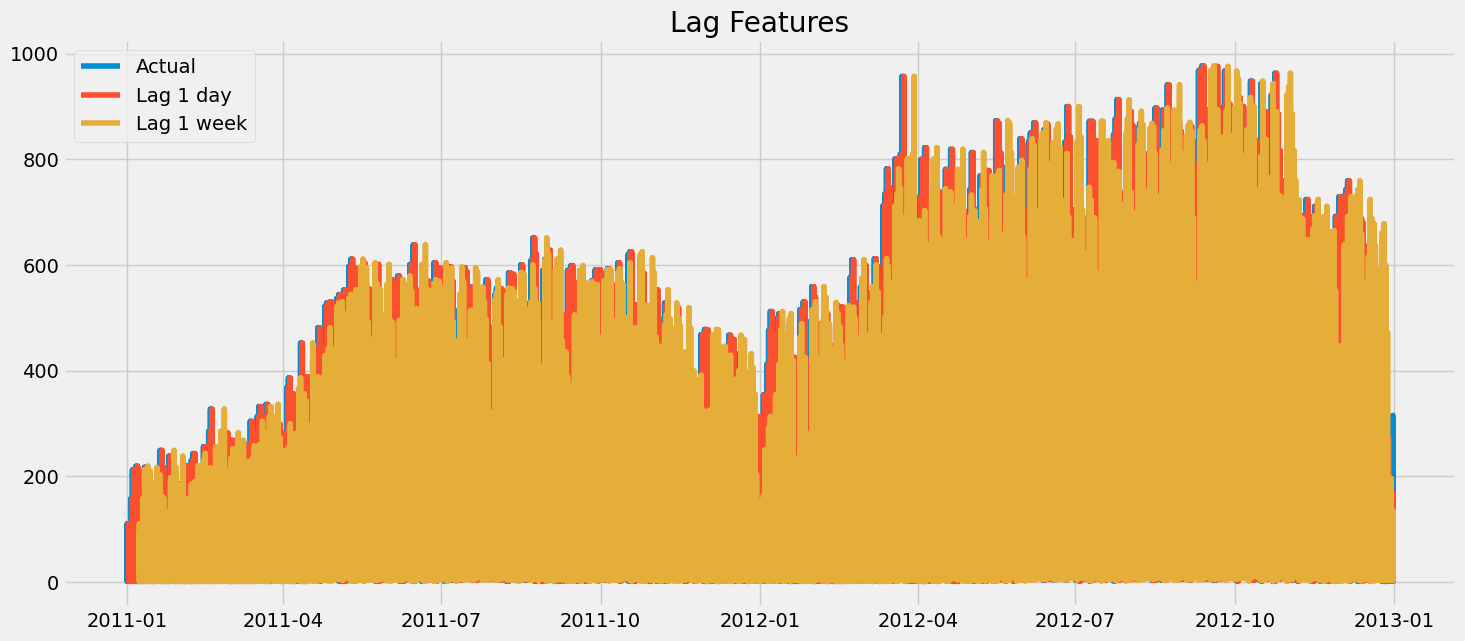

In [196]:
plt.clf()
plt.figure(figsize=(16, 7))
plt.plot(df['cnt'], label='Actual')
plt.plot(df['lag_1d'], label='Lag 1 day')
plt.plot(df['lag_1w'], label='Lag 1 week')
plt.legend()
plt.title('Lag Features')
plt.show()


In [197]:
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17379 entries, 2011-01-01 to 2012-12-31
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        17379 non-null  int64  
 1   yr            17379 non-null  int64  
 2   mnth          17379 non-null  int64  
 3   hr            17379 non-null  int64  
 4   holiday       17379 non-null  int64  
 5   weekday       17379 non-null  int64  
 6   workingday    17379 non-null  int64  
 7   weathersit    17379 non-null  int64  
 8   temp          17379 non-null  float64
 9   atemp         17379 non-null  float64
 10  hum           17379 non-null  float64
 11  windspeed     17379 non-null  float64
 12  casual        17379 non-null  int64  
 13  registered    17379 non-null  int64  
 14  cnt           17379 non-null  int64  
 15  lag_1d        17355 non-null  float64
 16  lag_1w        17211 non-null  float64
 17  lag_1m        16659 non-null  float64
 18  roll_mean

In [198]:
df = df.dropna()
df = df.reset_index()  # optional: reset the index if you want a simple range index
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16659 entries, 0 to 16658
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dteday        16659 non-null  datetime64[ns]
 1   season        16659 non-null  int64         
 2   yr            16659 non-null  int64         
 3   mnth          16659 non-null  int64         
 4   hr            16659 non-null  int64         
 5   holiday       16659 non-null  int64         
 6   weekday       16659 non-null  int64         
 7   workingday    16659 non-null  int64         
 8   weathersit    16659 non-null  int64         
 9   temp          16659 non-null  float64       
 10  atemp         16659 non-null  float64       
 11  hum           16659 non-null  float64       
 12  windspeed     16659 non-null  float64       
 13  casual        16659 non-null  int64         
 14  registered    16659 non-null  int64         
 15  cnt           16659 non-null  int64 

### 6. Implement XGBoost to predict how many bikes will be rented each hour of the last week and evaluate using appropriate metrics.

In [199]:
# For an hourly dataset, 7 days = 168 hours.
train = df.iloc[:-168].copy()   # Training set: all data except the last week
test = df.iloc[-168:].copy()      # Test set: the last week of data

print("Train shape:", train.shape)
print("Test shape:", test.shape)


Train shape: (16491, 21)
Test shape: (168, 21)


In [200]:
print("Test period from", test['dteday'].min(), "to", test['dteday'].max())


Test period from 2012-12-24 00:00:00 to 2012-12-31 00:00:00


In [201]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16659 entries, 0 to 16658
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   dteday        16659 non-null  datetime64[ns]
 1   season        16659 non-null  int64         
 2   yr            16659 non-null  int64         
 3   mnth          16659 non-null  int64         
 4   hr            16659 non-null  int64         
 5   holiday       16659 non-null  int64         
 6   weekday       16659 non-null  int64         
 7   workingday    16659 non-null  int64         
 8   weathersit    16659 non-null  int64         
 9   temp          16659 non-null  float64       
 10  atemp         16659 non-null  float64       
 11  hum           16659 non-null  float64       
 12  windspeed     16659 non-null  float64       
 13  casual        16659 non-null  int64         
 14  registered    16659 non-null  int64         
 15  cnt           16659 non-null  int64 

In [202]:
# Define the features for XGBoost; adjust based on your earlier feature engineering.
FEATURES_XGB = [
    'hr', 'weekday', 'mnth', 'yr',  # basic time features
    'lag_1d', 'lag_1w', 'lag_1m',     # lag features: 1 day, 1 week, 1 month lags
    'roll_mean_3h', 'roll_mean_3d'     # rolling means: last 3 hours, last 3 days
]
TARGET = 'cnt'

# Create training and test feature matrices and target vectors
X_train_xgb = train[FEATURES_XGB].copy()
y_train_xgb = train[TARGET].copy()
X_test_xgb = test[FEATURES_XGB].copy()
y_test_xgb = test[TARGET].copy()

# If any non-numeric column (e.g., 'dteday') exists in X, drop it.
for col in ['dteday']:
    if col in X_train_xgb.columns:
        X_train_xgb = X_train_xgb.drop(columns=[col])
    if col in X_test_xgb.columns:
        X_test_xgb = X_test_xgb.drop(columns=[col])

print("Features used:", FEATURES_XGB)
print(X_train_xgb.head())


Features used: ['hr', 'weekday', 'mnth', 'yr', 'lag_1d', 'lag_1w', 'lag_1m', 'roll_mean_3h', 'roll_mean_3d']
   hr  weekday  mnth  yr  lag_1d  lag_1w  lag_1m  roll_mean_3h  roll_mean_3d
0   9        3     2   0   116.0     9.0    16.0    109.000000     58.555556
1  10        3     2   0    47.0    36.0    40.0    113.000000     58.875000
2  11        3     2   0    51.0   108.0    32.0     78.666667     58.708333
3  12        3     2   0    55.0   238.0    13.0     59.000000     58.777778
4  13        3     2   0    52.0   144.0     1.0     63.666667     58.472222


In [203]:
dtrain = xgb.DMatrix(X_train_xgb, label=y_train_xgb)
dtest = xgb.DMatrix(X_test_xgb, label=y_test_xgb)

In [204]:
params = {
    'objective': 'reg:squarederror',  # Regression objective
    'eval_metric': 'rmse',             # Use RMSE for evaluation
    'max_depth': 3,                    # Maximum depth of trees
    'learning_rate': 0.01,             # Learning rate
    'colsample_bytree': 0.8,           # Subsample of features
    'subsample': 0.8,                  # Subsample ratio of observations
    'seed': 42
}

watchlist = [(dtrain, 'train'), (dtest, 'eval')]
num_round = 4000
early_stopping_rounds = 50

# Train the XGBoost model with early stopping
model = xgb.train(params, dtrain, num_round, watchlist, early_stopping_rounds=early_stopping_rounds, verbose_eval=100)

print("Best iteration:", model.best_iteration)


[0]	train-rmse:181.84154	eval-rmse:141.04831


c:\Users\Jlo\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[100]	train-rmse:93.21705	eval-rmse:69.95510
[200]	train-rmse:64.09801	eval-rmse:46.40726
[300]	train-rmse:54.60923	eval-rmse:37.84688
[400]	train-rmse:50.51881	eval-rmse:34.25171
[500]	train-rmse:47.82791	eval-rmse:32.14426
[600]	train-rmse:45.81953	eval-rmse:30.45631
[700]	train-rmse:44.29939	eval-rmse:29.00343
[800]	train-rmse:42.98005	eval-rmse:28.26026
[900]	train-rmse:41.93708	eval-rmse:27.59209
[1000]	train-rmse:40.99505	eval-rmse:27.18275
[1100]	train-rmse:40.12461	eval-rmse:26.74244
[1200]	train-rmse:39.35724	eval-rmse:26.46531
[1300]	train-rmse:38.67180	eval-rmse:26.22607
[1400]	train-rmse:38.00438	eval-rmse:26.02402
[1500]	train-rmse:37.36572	eval-rmse:25.81245
[1600]	train-rmse:36.75790	eval-rmse:25.60773
[1700]	train-rmse:36.22241	eval-rmse:25.46787
[1800]	train-rmse:35.73114	eval-rmse:25.27790
[1900]	train-rmse:35.29058	eval-rmse:25.21997
[2000]	train-rmse:34.84239	eval-rmse:25.13313
[2100]	train-rmse:34.35816	eval-rmse:25.05212
[2141]	train-rmse:34.22177	eval-rmse:25.069

In [205]:
print("Best iteration:", model.best_iteration)


Best iteration: 2092


XGBoost - Test RMSE: 25.06953342899816
XGBoost - Test MAE: 17.51432228088379


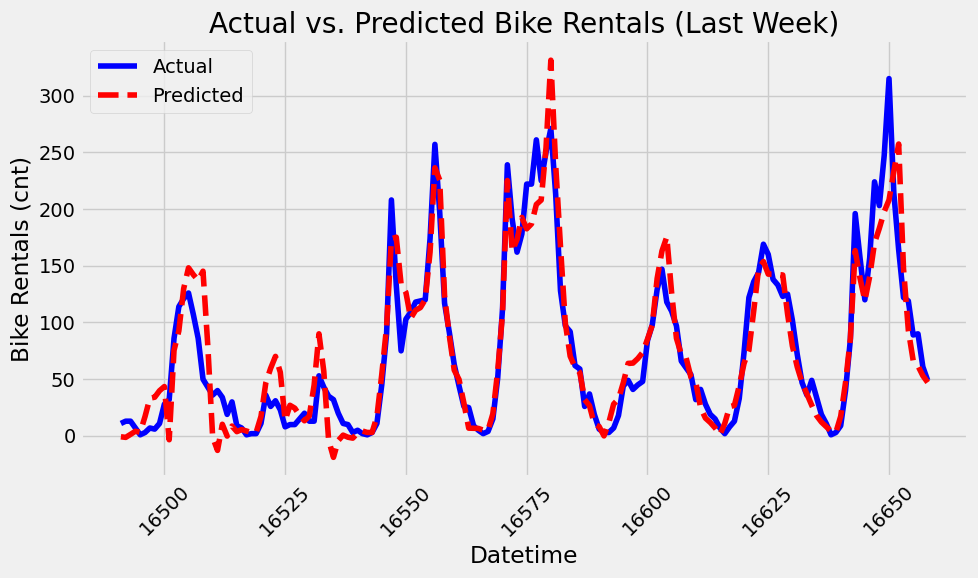

In [206]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predict on the test set
y_pred_xgb = model.predict(dtest)

# Calculate RMSE and MAE
rmse_xgb = np.sqrt(mean_squared_error(y_test_xgb, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test_xgb, y_pred_xgb)

print("XGBoost - Test RMSE:", rmse_xgb)
print("XGBoost - Test MAE:", mae_xgb)

# Plot actual vs. predicted counts for the last week
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_test_xgb, label='Actual', color='blue')
plt.plot(test.index, y_pred_xgb, label='Predicted', color='red', linestyle='dashed')
plt.title('Actual vs. Predicted Bike Rentals (Last Week)')
plt.xlabel('Datetime')
plt.ylabel('Bike Rentals (cnt)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
